In [1]:
# importing libs
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise
from keras.models import Model
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import SGD
import random as rn

In [2]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/vidits-kth/py-itpp.git


Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11.1).
autoconf set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libtool-doc gcj-jdk
The following NEW packages will be installed:
  libtool
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 161 kB of archives.
After this operation, 1,227 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Fetched 161 kB in 1s (196 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable 

In [ ]:
#CREATE A FILE IN py-itpp/src/comm WITH THE NAME reedsolomon.h AND PUT THIS PART
'''
#include <pybind11/pybind11.h>
#include <pybind11/operators.h>

#include <itpp/comm/reedsolomon.h>

namespace py = pybind11;




void generate_pybind_wrapper_for_itpp_reedsolomon_class( py::module &m, const char * name ) {

  py::class_<itpp::Reed_Solomon>( m, "Reed_Solomon" )
    .def( py::init<short, short,const bool,const short>() )

    .def("encode", static_cast<void (itpp::Reed_Solomon::*)(const itpp::bvec &, itpp::bvec &)>(&itpp::Reed_Solomon::encode))
    .def("encode", static_cast<itpp::bvec (itpp::Reed_Solomon::*)(const itpp::bvec &)>(&itpp::Reed_Solomon::encode))


    .def("decode", static_cast<void (itpp::Reed_Solomon::*)(const itpp::bvec &, itpp::bvec &)>(&itpp::Reed_Solomon::decode))
    .def("decode", static_cast<itpp::bvec (itpp::Reed_Solomon::*)(const itpp::bvec &)>(&itpp::Reed_Solomon::decode))

    .def("get_rate", &itpp::Reed_Solomon::get_rate)

  ;
}
'''

#CREATE A FILE IN py-itpp/src/comm WITH THE NAME reedsolomon.cpp AND PUT THIS PART
'''
#include "reedsolomon.h"

PYBIND11_MODULE(reedsolomon, m)
{
  generate_pybind_wrapper_for_itpp_reedsolomon_class( m, "Reed_Solomon" );
}
'''

#ADD THIS LINE IN py-itpp/src/comm/__init__.py
'''
from .reedsolomon import *
'''

In [3]:
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .
!cd py-itpp; ls ; pip3 install -e .
!cat py-itpp/setup.py
#following 3 lines are added to resolve the issue
import sys
sys.path.append('./py-itpp/lib')
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 10.4 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,372 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,866 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:

In [4]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [8]:
def rs_64qam(bits,m,t,SNRs):

  BER = []


  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.QAM(64)
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect
    EbNo=10.0**(snr/10.0)
    noise_variance = 1/(2*rate*EbNo)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER


In [9]:
def rs_16qam(bits,m,t,SNRs):

  BER = []

  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.QAM(16)
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect
    EbNo=10.0**(snr/10.0)
    noise_variance = 1/(2*rate*EbNo)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER


In [10]:
def rs_8psk(bits,m,t,SNRs):

  BER = []

  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.PSK(8)
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect
    EbNo=10.0**(snr/10.0)
    noise_variance = 1/(2*rate*EbNo)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER


In [11]:
def rs_qpsk(bits,m,t,SNRs):

  BER = []

  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.QPSK()
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect
    EbNo=10.0**(snr/10.0)
    noise_variance = 1/(2*rate*EbNo)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER


In [23]:
def rs_bpskc(bits,m,t,SNRs):

  BER = []

  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.BPSK_c()
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect
    EbNo=10.0**(snr/10.0)
    noise_variance = 1/(2*rate*EbNo)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER


In [26]:
snrs = np.arange(0,18.5,0.5)

#Generating Random bits
source_bits = itpp.randb(500000)

ber_rs_qp = rs_qpsk(source_bits, 3, 2, snrs)
print("------------Calculating BLER for QPSK------------")
ber_rs_8p = rs_8psk(source_bits, 3, 2, snrs)
print("------------Calculating BLER for 8PSK------------")
ber_rs_16q = rs_16qam(source_bits, 3, 2, snrs)
print("------------Calculating BLER for 16QAM------------")
ber_rs_64q = rs_64qam(source_bits, 3, 2, snrs)
print("------------Calculating BLER for 64QAM------------")

In [30]:
ber_rs_bp = rs_bpskc(source_bits, 3, 2, snrs)
print("------------Calculating BLER for BPSK------------")

In [27]:
def autoenco(k,n,SNRs):
  BER = []
  R = float(k/n)
  Nt = 10000
  M = 2**k
  label = np.random.randint(M,size=Nt)
  data = []
  for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
  data = np.array(data)



  input_signal = Input(shape=(M,))
  encoded = Dense(M, activation='relu')(input_signal)
  encoded1 = Dense(n, activation='linear')(encoded)
  encoded2 = BatchNormalization()(encoded1)

  EbNo_train = 10 ** (0.7)
  encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

  decoded = Dense(M, activation='relu')(encoded3)
  decoded1 = Dense(M, activation='softmax')(decoded)

  autoencoder = Model(input_signal, decoded1)
  #sgd = SGD(lr=0.001)
  autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
  print(autoencoder.summary())

  N_val = 1500
  val_label = np.random.randint(M,size=N_val)
  val_data = []
  for i in val_label:
    temp = np.zeros(M)
    temp[i] = 1
    val_data.append(temp)
  val_data = np.array(val_data)

  autoencoder.fit(data, data,epochs=30,batch_size=300,validation_data=(val_data, val_data),callbacks=[ModelCheckpoint(save_best_only=True, filepath="ok")])
  autoencoder.load_weights("ok")

  encoder = Model(input_signal, encoded2)
  encoded_input = Input(shape=(n,))

  deco = autoencoder.layers[-2](encoded_input)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = Model(encoded_input, deco)

  N = 50000
  test_label = np.random.randint(M,size=N)
  test_data = []

  for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)

  test_data = np.array(test_data)

  for snr in SNRs:
    EbNo=10.0**(snr/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    noise = np.random.normal(0,noise_std,(N,n))
    encoded_signal = encoder.predict(test_data)
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    BER.append(no_errors / N)
  return BER

In [34]:
from keras.callbacks import ModelCheckpoint

In [32]:
ber_autoenco = autoenco(3, 7, snrs)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dense_21 (Dense)            (None, 7)                 63        
                                                                 
 batch_normalization_5 (Batc  (None, 7)                28        
 hNormalization)                                                 
                                                                 
 gaussian_noise_5 (GaussianN  (None, 7)                0         
 oise)                                                           
                                                                 
 dense_22 (Dense)            (None, 8)                 64 

34/34 [==============================] - 2s 57ms/step - loss: 1.1562 - val_loss: 1.6806
Epoch 5/30
34/34 [==============================] - 2s 46ms/step - loss: 0.9504 - val_loss: 1.4664
Epoch 6/30
34/34 [==============================] - 1s 34ms/step - loss: 0.7981 - val_loss: 1.2467
Epoch 7/30
34/34 [==============================] - 1s 35ms/step - loss: 0.6724 - val_loss: 1.0252
Epoch 8/30
34/34 [==============================] - 1s 35ms/step - loss: 0.5590 - val_loss: 0.8143
Epoch 9/30
34/34 [==============================] - 1s 33ms/step - loss: 0.4523 - val_loss: 0.6164
Epoch 10/30
34/34 [==============================] - 1s 43ms/step - loss: 0.3532 - val_loss: 0.4486
Epoch 11/30
34/34 [==============================] - 1s 34ms/step - loss: 0.2666 - val_loss: 0.3100
Epoch 12/30
34/34 [==============================] - 1s 35ms/step - loss: 0.1975 - val_loss: 0.2069
Epoch 13/30
34/34 [==============================] - 1s 35ms/step - loss: 0.1471 - val_loss: 0.1383
Epoch 14/30
34/34

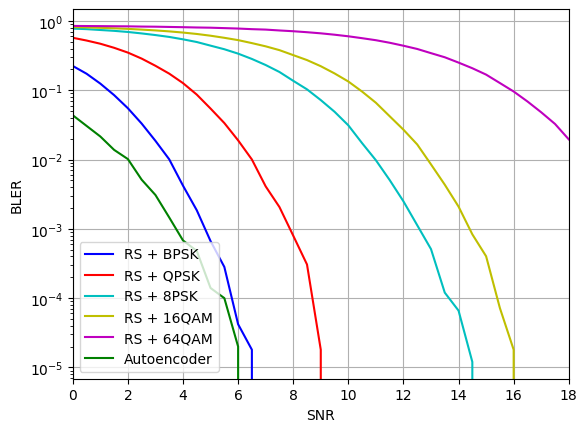

In [33]:
plt.figure()
plt.grid(True)
plt.xlim(0,18)
plt.xlabel('SNR')
plt.ylabel('BLER')
plt.semilogy(snrs, ber_rs_bp, c = 'b', label = 'RS + BPSK')
plt.semilogy(snrs, ber_rs_qp, c = 'r', label = 'RS + QPSK')
plt.semilogy(snrs, ber_rs_8p, c = 'c', label = 'RS + 8PSK')
plt.semilogy(snrs, ber_rs_16q, c = 'y', label = 'RS + 16QAM')
plt.semilogy(snrs, ber_rs_64q, c = 'm', label = 'RS + 64QAM')
plt.semilogy(snrs, ber_autoenco, c = 'g', label = 'Autoencoder')
plt.legend(loc='best')